<a href="https://colab.research.google.com/github/hwangswan/movie-reviews-sa/blob/main/MovieReviewSA_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Review Sentiment Analysis

(Building a naive CNN with TensorFlow & BERT)



In [ ]:
import pandas as pd
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from tqdm import tqdm

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

import tensorflow as tf
print(tf.version.VERSION)

2.3.0


In [ ]:
!git clone --depth 1 -b v2.8.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [ ]:
!pip install -Uqr models/official/requirements.txt

In [ ]:
import tensorflow_hub as hub
import sys
sys.path.append('models')

from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.3.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


## Importing data

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
zip_data = '/gdrive/MyDrive/Colab Notebooks/sentiment-analysis-on-movie-reviews.zip'

with zipfile.ZipFile(zip_data, 'r') as f:
    f.extractall('/content/data/')

In [ ]:
test_zip = '/content/data/test.tsv.zip'

with zipfile.ZipFile(test_zip, 'r') as f:
    f.extractall('/content/data/')

In [ ]:
train_zip = '/content/data/train.tsv.zip'

with zipfile.ZipFile(train_zip, 'r') as f:
    f.extractall('/content/data/')

## First look at the data

In [ ]:
train_tsv = '/content/data/train.tsv'
test_tsv = '/content/data/test.tsv'

In [ ]:
train_df = pd.read_csv(train_tsv, sep = '\t')

In [ ]:
train_df.shape

(156060, 4)

In [ ]:
train_df.iloc[0]

PhraseId                                                      1
SentenceId                                                    1
Phrase        A series of escapades demonstrating the adage ...
Sentiment                                                     1
Name: 0, dtype: object

Drop PhraseId and SentenceId, since I guess it's useless btw

In [ ]:
train_df = train_df.drop('PhraseId', axis = 1)
train_df = train_df.drop('SentenceId', axis = 1)

In [ ]:
train_df

,Phrase,Sentiment
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2
3,A,2
4,series,2
...,...,...
156055,Hearst 's,2
156056,forced avuncular chortles,1
156057,avuncular chortles,3
156058,avuncular,2


Plotting sentiments

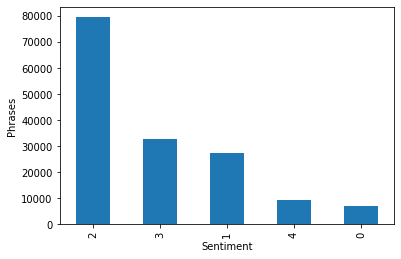

In [ ]:
counts = train_df['Sentiment'].value_counts()
counts.plot.bar()
plt.xlabel('Sentiment')
plt.ylabel('Phrases')
plt.show()

## Preprocessing
Steps of preprocessing include:
- Creating tf.data.Dataset for Training and Evaludation

In [ ]:
train_df, remaining = train_test_split(train_df, random_state = 42, train_size = 0.075, stratify = train_df['Sentiment'].values)
valid_df, _ = train_test_split(remaining, random_state = 42, train_size = 0.0075, stratify = remaining['Sentiment'].values)
train_df.shape, valid_df.shape

((11704, 2), (1082, 2))

In [ ]:
with tf.device('/cpu:0'):
    train_data = tf.data.Dataset.from_tensor_slices(
        (train_df['Phrase'].values, train_df['Sentiment'].values)
    )

    valid_data = tf.data.Dataset.from_tensor_slices(
        (valid_df['Phrase'].values, valid_df['Sentiment'].values)
    )

for p, s in train_data.take(1):
    print(p, s)

for p, s in valid_data.take(1):
    print(p, s)

tf.Tensor(b'American History X', shape=(), dtype=string) tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(b"'s clear why Deuces Wild , which was shot two years ago , has been gathering dust on MGM 's shelf .", shape=(), dtype=string) tf.Tensor(1, shape=(), dtype=int64)


## Download a pre-trained BERT model from TensorFlow Hub

In [ ]:
# Label categories
label_list = [0, 1, 2, 3, 4]

# Maximum length of token input sequences
max_seq_length = 128
train_batch_size = 32

# Get BERT layer and tokenizer
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2', trainable = True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
tokenizer.wordpiece_tokenizer.tokenize('a broken family')

['a', 'broken', 'family']

In [ ]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('a broken family'))

[1037, 3714, 2155]

## Tokenize and preprocess text for BERT

In [ ]:
def to_feature(text, label, label_list = label_list, max_seq_length = max_seq_length, tokenizer = tokenizer):
    example = classifier_data_lib.InputExample(
        guid = None,
        text_a = text.numpy(),
        text_b = None,
        label = label.numpy()
    )

    feature = classifier_data_lib.convert_single_example(
        0, example, label_list, max_seq_length, tokenizer
    )

    return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

In [ ]:
def to_feature_map(text, label):
    input_ids, input_mask, segment_ids, label_id = tf.py_function(
        to_feature, inp = [text, label],
        Tout = [tf.int32, tf.int32, tf.int32, tf.int32]
    )

    input_ids.set_shape([max_seq_length])
    input_mask.set_shape([max_seq_length])
    segment_ids.set_shape([max_seq_length])
    label_id.set_shape([])

    x = {
        'input_word_ids' : input_ids,
        'input_mask' : input_mask,
        'input_type_ids' : segment_ids
    }

    return (x, label_id)

In [ ]:
with tf.device('/cpu:0'):
    # train
    train_data = (train_data.map(
        to_feature_map,
        num_parallel_calls = tf.data.experimental.AUTOTUNE
    )
    .shuffle(1000)
    .batch(32, drop_remainder = True)
    .prefetch(tf.data.experimental.AUTOTUNE))

    # valid
    valid_data = (valid_data.map(
        to_feature_map,
        num_parallel_calls = tf.data.experimental.AUTOTUNE
    )
    .batch(32, drop_remainder = True)
    .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [ ]:
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [ ]:
def create_model():
    input_word_ids = tf.keras.layers.Input(shape = (max_seq_length,), dtype = tf.int32,
                                           name = 'input_word_ids')
    
    input_mask = tf.keras.layers.Input(shape = (max_seq_length,), dtype = tf.int32,
                                       name = 'input_mask')
    
    input_type_ids = tf.keras.layers.Input(shape = (max_seq_length,), dtype = tf.int32,
                                       name = 'input_type_ids')
    
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

    drop = tf.keras.layers.Dropout(0.4)(pooled_output)

    output = tf.keras.layers.Dense(5, activation = 'softmax', name = 'output')(drop)

    model = tf.keras.Model(
        inputs = {
            'input_word_ids' : input_word_ids,
            'input_mask' : input_mask,
            'input_type_ids' : input_type_ids
        },
        outputs = output
    )

    return model

In [ ]:
model = create_model()
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-5),
    loss = tf.keras.losses.sparse_categorical_crossentropy,
    metrics = ['sparse_categorical_accuracy']
)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

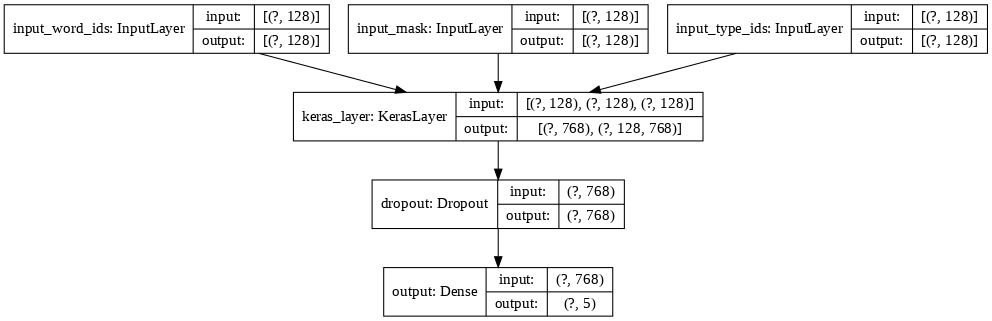

In [ ]:
tf.keras.utils.plot_model(model = model, show_shapes = True, dpi = 76)

## Train model

In [ ]:
epochs = 4
hist = model.fit(train_data,
                 validation_data = valid_data,
                 epochs = epochs,
                 batch_size = train_batch_size,
                 verbose = 1)

Epoch 1/4
365/365 [==============================] - ETA: 0s - loss: 1.0491 - sparse_categorical_accuracy: 0.5748WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0423s vs `on_test_batch_end` time: 0.4950s). Check your callbacks.


365/365 [==============================] - 575s 2s/step - loss: 1.0491 - sparse_categorical_accuracy: 0.5748 - val_loss: 0.8175 - val_sparse_categorical_accuracy: 0.6657
Epoch 2/4
365/365 [==============================] - 573s 2s/step - loss: 0.7604 - sparse_categorical_accuracy: 0.6940 - val_loss: 0.8112 - val_sparse_categorical_accuracy: 0.6506
Epoch 3/4
365/365 [==============================] - 573s 2s/step - loss: 0.5946 - sparse_categorical_accuracy: 0.7691 - val_loss: 1.0156 - val_sparse_categorical_accuracy: 0.6127
Epoch 4/4
365/365 [==============================] - 574s 2s/step - loss: 0.4359 - sparse_categorical_accuracy: 0.8317 - val_loss: 1.0693 - val_sparse_categorical_accuracy: 0.6572


Evaluating BERT Text Classification Model

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

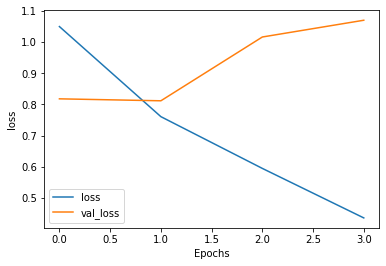

In [ ]:
plot_graphs(hist, 'loss')

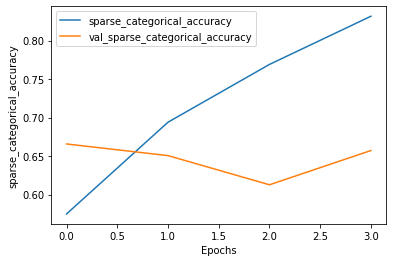

In [ ]:
plot_graphs(hist, 'sparse_categorical_accuracy')

In [ ]:
def get_labels_from_tfdataset(tfdataset, batched = False):
    labels = list(map(lambda x : x[1].numpy(), tfdataset))

    if not batched:
        return tf.concat(labels, axis = 0)

    return labels

In [ ]:
y_test = get_labels_from_tfdataset(valid_data)
y_pred = [np.argmax(s) for s in model.predict(valid_data)]

In [ ]:
print(len(y_test))

1056


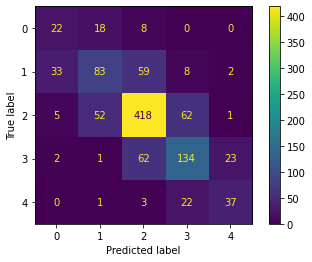

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels = label_list)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = label_list)
disp.plot()

In [ ]:
# Classification Report
print(classification_report(y_test, y_pred, target_names = [str(x) for x in label_list]))

              precision    recall  f1-score   support

           0       0.35      0.46      0.40        48
           1       0.54      0.45      0.49       185
           2       0.76      0.78      0.77       538
           3       0.59      0.60      0.60       222
           4       0.59      0.59      0.59        63

    accuracy                           0.66      1056
   macro avg       0.57      0.57      0.57      1056
weighted avg       0.66      0.66      0.66      1056



## Create submission

Now we have the submission model, let's predict and write predictions to submission file.

In [ ]:
test_df = pd.read_csv(test_tsv, sep = '\t')

In [ ]:
list_phrase_ids = test_df['PhraseId']
list_phrases = test_df['Phrase']

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices((list_phrases, [0] * len(list_phrases)))
test_data = (test_data.map(to_feature_map).batch(1))

sentiments = model.predict(test_data)

In [ ]:
pd.DataFrame({
    'PhraseId' : list_phrase_ids,
    'Sentiment' : [np.argmax(s) for s in sentiments]
}).to_csv('submission.csv', index = False)